## Bài 2.
Theo như mô tả trong [links](https://www.kaggle.com/c/dont-overfit-ii/notebooks), dữ liệu này có 302 cột, trong đó
- `id`: đánh số thứ tự, ta có thể lấy nó làm `index` cho mỗi dòng
- `target`: là một biến nhị phân chỉ có 2 giá trị 0, 1 và ở đây nó chính là $y$ trong bài toán dự đoán này
- Các cột còn lại `0 - 299`: là các biến số liên tục

In [1]:
import numpy as np 
import pandas as pd
import os

df_b2_train = pd.read_csv(r'../input/dont-overfit-ii/train.csv')
print(df_b2_train.shape)
df_b2_train.head()

(250, 302)


,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


Tiếp theo, nhìn sơ lược có cái chó gì trong tập test!

In [2]:
df_b2_test = pd.read_csv(r'../input/dont-overfit-ii/test.csv')
print(df_b2_test.shape)
df_b2_test.head()

(19750, 301)


,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,...,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,...,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,...,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,...,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,...,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


Như vậy, 2 dữ liệu này giống nhau ở tên các cột `id, 0,1,...,299` và chỉ khác duy nhất ở số dòng trong `test.csv` nhiều hơn trong `train.csv` và riêng cột `target` được cho trong `train.csv` để xây dựng mô hình.

Vì yêu cầu bài toán là chọn ra các thành phần có ý nghĩa nhất bằng 5 phương pháp:
- `PCA` : phân tích thành phần chính (là công cụ hữu hiệu trong quy tắc giảm số chiều : `"Dimensionality Reduction"`)
- `Feature selection`: chẳng hạn dùng `SelectKBest` trong `sklearn.feature_selection` để chọn lọc các biến có ý nghĩa nhất.
- `XGBoost`

Sự khác biệt cơ bản của 2 phương pháp này:
- PCA dựa vào ma trận hiệp phương sai để tạo ra phép chiếu lên không gian số chiều thấp, do đó dữ liệu sau khi thực hiện PCA đã bị biến đổi so với ban đầu.
- Trong khi `Feature selection` chỉ chọn ra những biến có ý nghĩa nhất từ dữ liệu gốc nên bảo toàn được dáng vẻ của dữ liệu.

Do đó, đầu tiên, ta phải thực hiện các thao tác xử lý dữ liệu thô như loại bỏ dữ liệu khuyết trước khi tiến hành 2 phương pháp này.

#### Tách dữ liệu

In [3]:
x_train = df_b2_train.drop(columns = ['id', 'target'])
y_train = df_b2_train['target']

x_test = df_b2_test.drop(columns = ['id'])

#### Bước 1. Kiểm tra sơ lược dữ liệu khuyết và lựa chọn mức loại bỏ.

Việc lựa chọn `ngưỡng (threshold)` quá cao hoặc quá thấp đều ảnh hưởng không tốt đến mô hình, khi đó nó có thể loại bỏ quá nhiều dữ liệu quan trọng ở các cột khác hoặc giữ lại nhiều dữ liệu có khả năng gây nhiễu đến việc huấn luyện và dự đoán mô hình.

#### Bước 2. Chon một ngưỡng nào đó

Lưu ý rằng dữ liệu của ta trong tập `train` lấy từ file `train.csv` này có rất ít data, vì vậy nên chon `threshold` ở một mức vừa phải.

In [4]:
threshold = 0.25
quasi_constant_feature = []

for feature in x_train.columns:

    # Tính tỷ số về các giá trị duy nhất ở từng cột rồi so sánh với ngưỡng threshold.
    predominant = (x_train[feature].value_counts() / np.float(len(x_train))).sort_values(ascending=False).values[0]
    
    # Nếu cột nào có số giá trị duy nhất (distinct / unique) vượt quá ngưỡng; đưa vào sổ đen 
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

# Loại bỏ các côt có tên trong "sổ đen (quasi_constant_feature)" này
print(quasi_constant_feature)
x_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)
x_test.drop(labels=quasi_constant_feature, axis=1, inplace=True)

[]
[]


#### Kế tiếp, kiểm tra các feature có lặp lại?

In [5]:
# Chuyển vị dữ liệu x_train
train_features_T = x_train.T

# Kiểm xem có bao nhiêu giá trị bị trùng lặp theo dòng (droping duplicated observations)
print(train_features_T.duplicated().sum())

# Các cột có nhiều giá trị bị trùng lặp
duplicated_columns = train_features_T[train_features_T.duplicated()].index.values

# Bỏ đi những cột đó
print(x_train.drop(labels=duplicated_columns, axis=1, inplace=True))
print(x_test.drop(labels=duplicated_columns, axis=1, inplace=True))

0
None
None


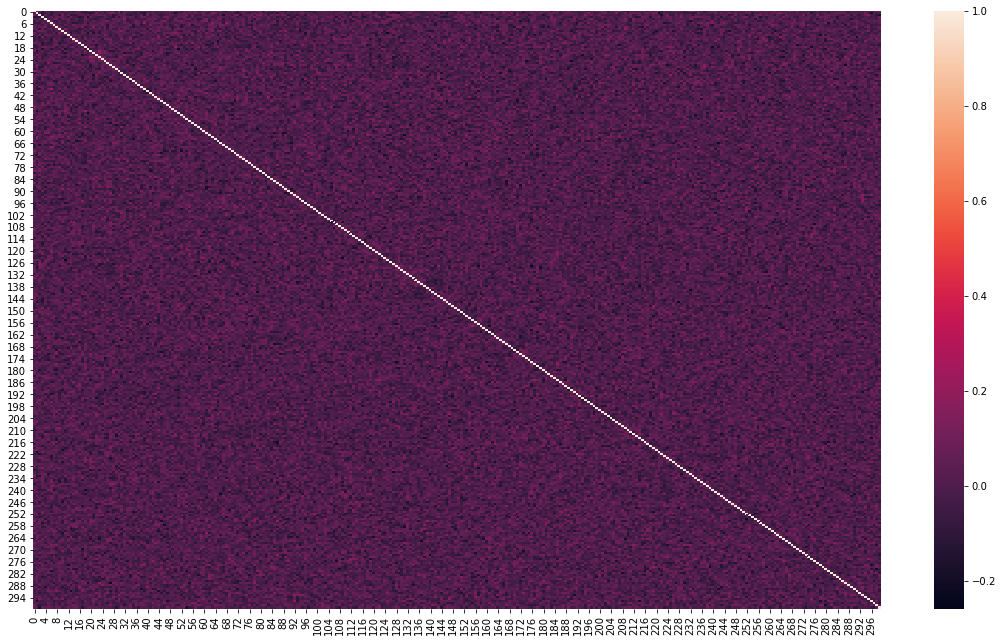

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


# creating set to hold the correlated features
corr_features = set()

# Tính ma trận các hệ số tương quan, để từ đó có đánh giá tương quan nội suy giữa các biến đến mô hình
corr_matrix = x_train.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(19, 11))
sns.heatmap(corr_matrix)

for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)

## bỏ dữ liệu không quan trọng            
x_train.drop(labels=corr_features, axis=1, inplace=True)
x_test.drop(labels=corr_features, axis=1, inplace=True)

### Cách 1, Dùng `XGBoost`

Lưu ý: 
- Nếu xét `Chi-squared sccores` thì dữ liệu đầu vào `X` phải là các số không âm!

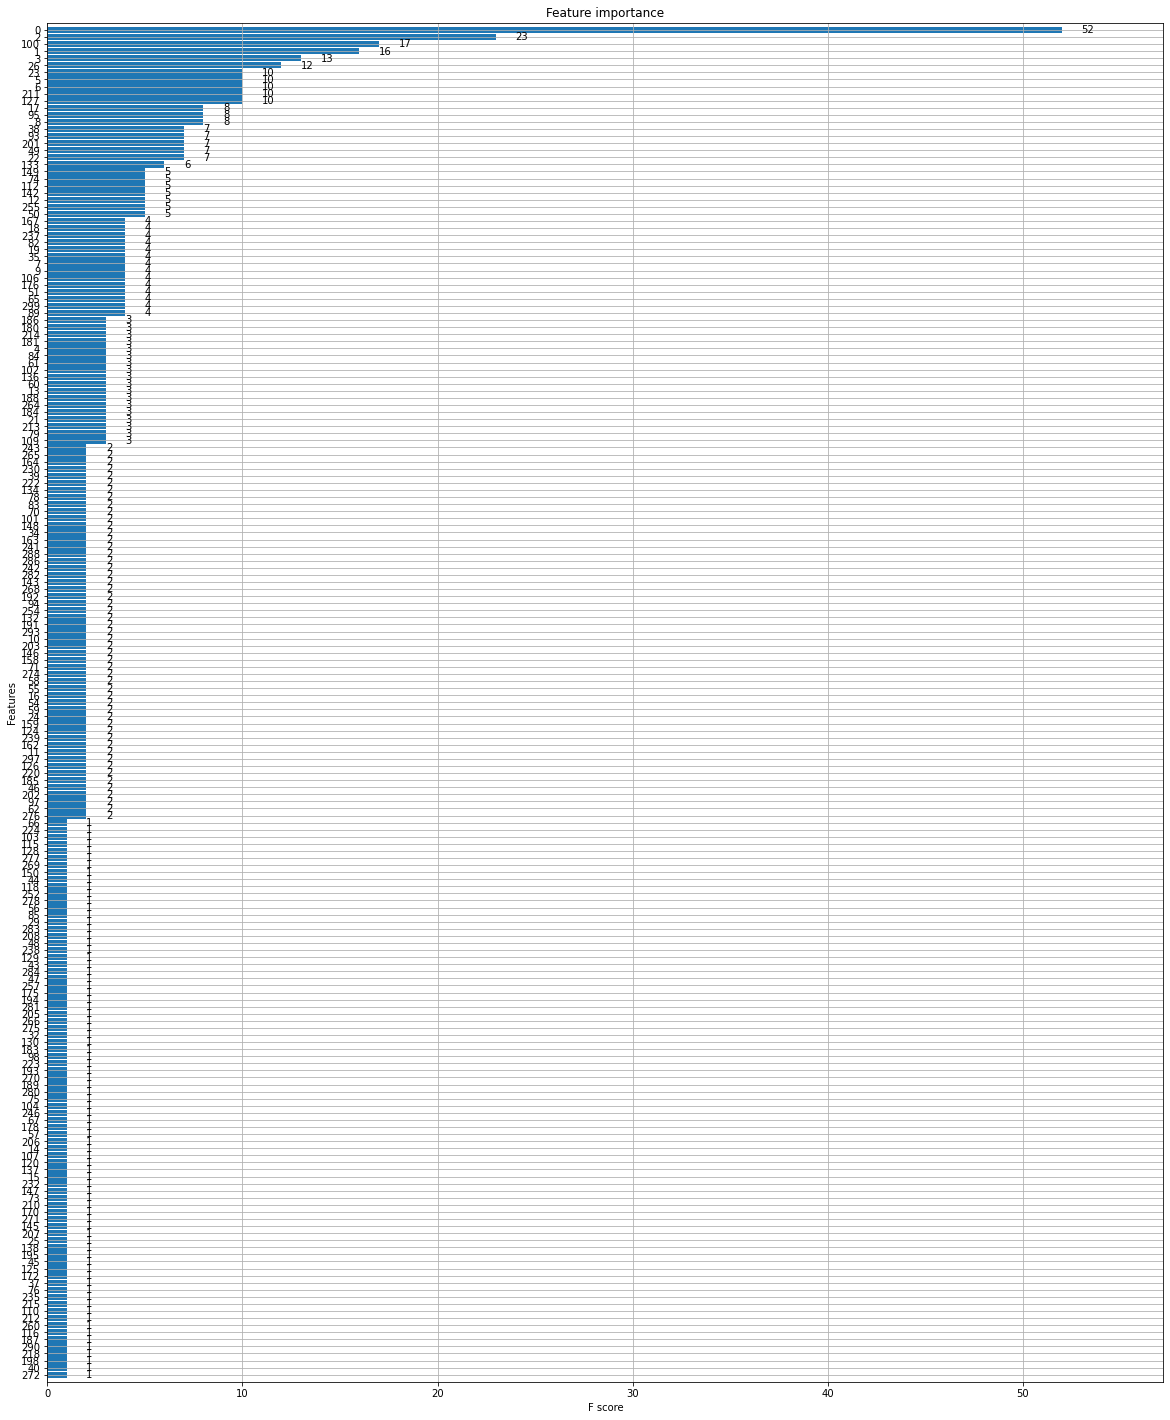

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

reg = xgb.XGBRegressor(n_estimators = 10000)
reg.fit(x_train[:150], y_train[:150], 
        eval_set=[(x_train[:150], y_train[:150]), (x_train[150:], y_train[150:])] ,
        early_stopping_rounds = 50, verbose = 0)
print()
fig, ax = plt.subplots(1,1, figsize = (20, 25))
plot_importance(reg, height = 0.9, ax = ax);

Như vậy, nhìn vào biểu đồ trên, với `XGB` với các feature: `0, 2, 100, 1, 23, 26` là các cột có ảnh hưởng lớn hơn hẳn phần còn lại và có ảnh hưởng lón đến mô hình

### Cách 2. SelectKBest
Chọn K feature tốt nhất từ dữ liệu

In [8]:
# Nhập các thư viện cần cho hướng này
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Chọn số feature có ảnh hướng cao nhất.
select_k = 10
y_train = df_b2_train['target']

# chỉ giữ lại các feature dạng số, đéo quan tâm dữ liệu string.
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]


# Khởi tạo mô hình SeleckKBest: chọn K feature tốt nhất.
selection = SelectKBest(mutual_info_classif, k=select_k).fit(numerical_x_train, y_train)

# In nó ra.
features = x_train.columns[selection.get_support()]
print(list(features))

['34', '47', '75', '133', '164', '169', '179', '213', '220', '297']


### Cách 3. RandomForest

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# khởi tạo mô hình
rfc = RandomForestClassifier(n_estimators=100)

# Chọn feature
select_model = SelectFromModel(rfc)

# Huấn luyện mô hình
fit = select_model.fit(x_train, y_train)

# Biến đổi dữ liệu
model_features = fit.transform(x_train)

## Trả ra kết quả các cột có ý nghĩa
selected_feat = x_train.columns[(select_model.get_support())]
selected_feat

Index(['1', '2', '3', '6', '10', '16', '18', '20', '23', '29',
       ...
       '272', '275', '276', '284', '285', '287', '290', '292', '298', '299'],
      dtype='object', length=117)

### Cách 4. RRE.

In [10]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# khởi tạo mô hình
rfc = RandomForestClassifier(n_estimators = 100)

## chon 5 feature co y nghia nhat de fit mo hinh
rfe = RFE(estimator = rfc, n_features_to_select = 5)
fit = rfe.fit(x_train, y_train)

## Tra ra cac feature co y nghia nhat
selected_feat = x_train.columns[(fit.support_)]
selected_feat

Index(['59', '126', '127', '133', '176'], dtype='object')

### Cách 5. PCA

Hướng 1. Khai báo `n_components` là số thành phần chính hay số chiều mới của dữ liệu sau khi thực hiện biến đổi SVD.

In [11]:
from sklearn.decomposition import PCA

## giả sử số thàng phần chính bằng 5, tức là chọn 5 giá trị vector cột đầu tiên trong biến đổi nhân ma trận qua thuật toán SVD
pca = PCA(n_components = 5)
pca.fit(x_train)

## biến đổi dữ liệu
x_train_pca1 = pca.transform(x_train)

## kiểm tra số chiều ma trận có phải có 5 (số thành phần chính) cột hay không
x_train_pca1.shape

(250, 5)

Hướng 2. Khai báo tỷ lệ ý nghĩa mô hình

In [12]:
## Khai báo mô hình với mức bảo toàn dữ liệu là 0.99 từ dữ liệu gốc.
pca2 = PCA(0.99)

## 
pca2.fit(x_train)
x_train_pca2 = pca2.transform(x_train)

x_train_pca2.shape

(250, 208)

# Bài 4.
Dữ liệu này sẽ được xử lý tương tự như trong bài 2.

Lưu ý rằng:
- x_train sẽ không chứa các cột `id` , `target` (load dataset lên rồi chọn cột nào để loại bỏ)
- Sau đó thực hiện tương tự như bài trên

In [13]:
df_b4_train = pd.read_csv(r'../input/dum-kaggle/train.csv')
df_b4_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [14]:
df_b4_test = pd.read_csv(r'../input/dum-kaggle/test.csv')
df_b4_test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


**Tách dữ liệu**

In [15]:
x_train = df_b4_train.drop(columns = ['ID', 'TARGET'])
y_train = df_b4_train['TARGET']

x_test = df_b4_test.drop(columns = ['ID'])

Các bước còn lại làm tương tự như trên bài 2.

In [18]:
import keras